In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import nltk
#nltk.download()
from nltk.corpus import stopwords
from spellchecker import SpellChecker


import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
import re 

%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff




2023-01-28 02:23:08.915472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 02:23:09.213209: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-28 02:23:09.256808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-28 02:23:09.256831: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

# 1- Loading Data

In [2]:
train = pd.read_csv('Data/train.csv')
#validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('Data/test.csv')

Looking to our data

In [3]:
type(train['target'])

pandas.core.series.Series

## Class distribution¶


<BarContainer object of 2 artists>

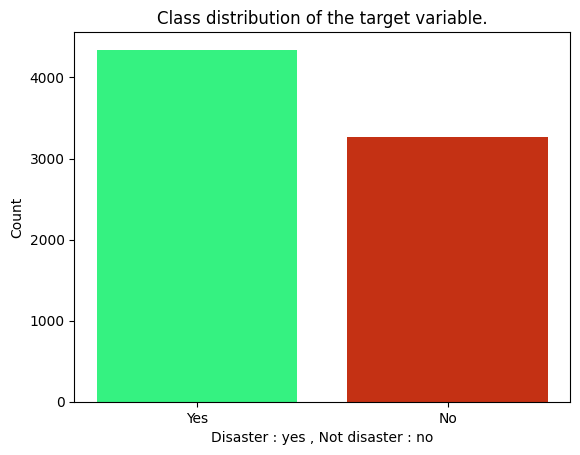

In [4]:
x = train.target.value_counts()
plt.bar(['Yes', 'No'], x)
plt.xlabel("Disaster : yes , Not disaster : no")
plt.ylabel("Count")
plt.title("Class distribution of the target variable.") 
plt.bar(np.arange(2), x, color=['#35F281','#C43114'])


## Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

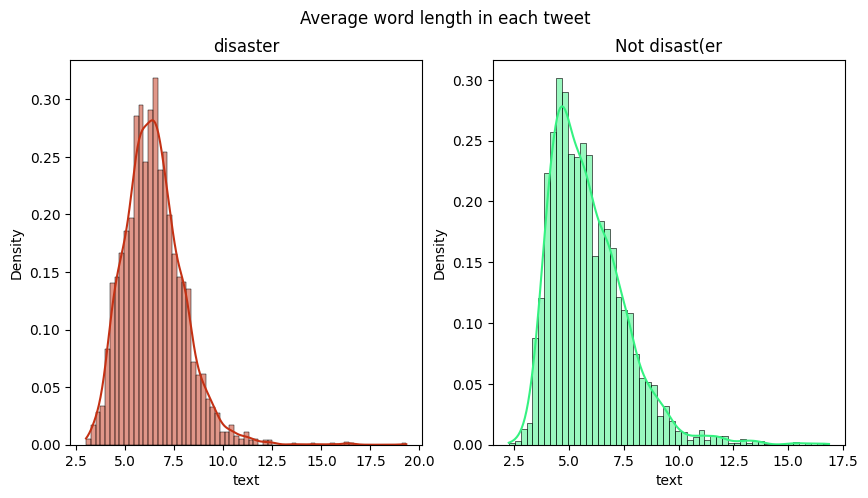

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#C43114', kde=True, stat="density")
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#35F281',kde=True, stat="density")
ax2.set_title('Not disast(er')
fig.suptitle('Average word length in each tweet')

## Common stopwords in tweets¶


They are common words in a language that are typically filtered out before or during the processing of natural language text. Examples of stop words in English include "the," "and," "is," "of," and "in." These words are often removed from text data because they do not carry significant meaning and can add noise to the data, making it more difficult to extract useful information. However, in some NLP projects, stop words can be useful to keep depending on the task and the context of the project.

### class 0

<BarContainer object of 10 artists>

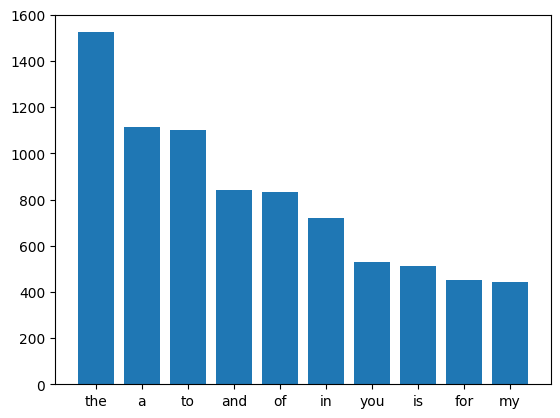

In [6]:

def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

from collections import defaultdict
corpus = create_corpus(0)
stop = stopwords.words('english')
dic= defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

### class 1 

<BarContainer object of 10 artists>

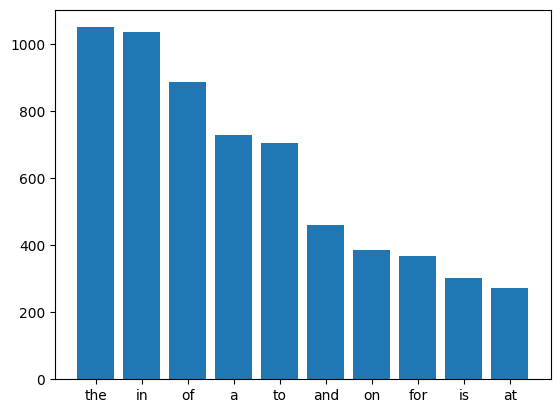

In [7]:

def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

from collections import defaultdict
corpus = create_corpus(1)
stop = stopwords.words('english')
dic= defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

## should we remove stop words ord not ? 
This is because stop words such as "the", "and", "is", "of", and "in" can contain important information about the context of the tweet, such as location and time. For example, a tweet containing the word "earthquake" along with the stop word "in" and a specific location, would give more information about the context of the tweet.

Additionally, stop words can be useful for identifying patterns and features that are specific to tweets about actual disasters. For example, a tweet about an actual disaster might contain words like "help", "emergency", "evacuate", "injured", etc. These words are not necessarily stop words, but they are common in tweets about disasters.

Keep in mind, however, that this decision also depends on how much text data you have available and how computationally intensive your analysis is. If you have a lot of text data and your analysis is computationally expensive, removing stop words can reduce the dimensionality of the data and make it more manageable.




### Punctuation


Punctuation can have a significant impact on natural language processing (NLP) projects, as it can provide important information about the structure and meaning of text. Punctuation can be used to indicate sentence boundaries, clarify meaning, and convey tone or emphasis.

In NLP tasks such as text classification, sentiment analysis, and language translation, punctuation can be used to identify patterns and features that are specific to the task. For example, in sentiment analysis, the presence of exclamation marks or question marks can indicate strong emotions or uncertainty, respectively.

However, in some tasks such as text generation, text summarization, and text-to-speech, removing punctuation might be beneficial to improve the fluency and coherence of the generated text.

<BarContainer object of 18 artists>

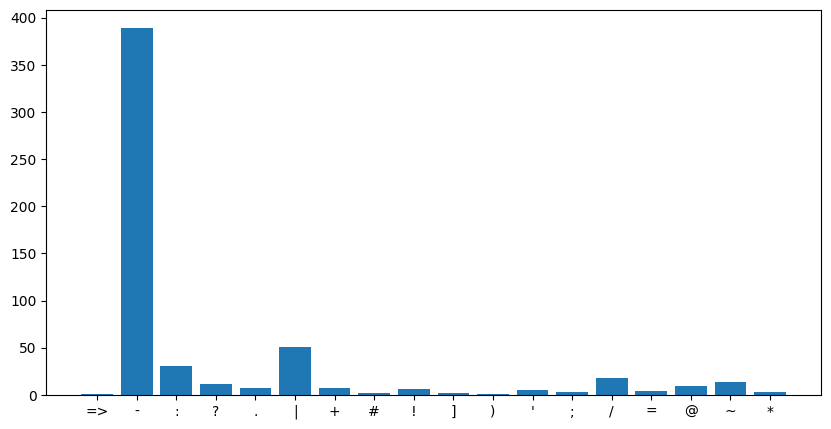

In [8]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

### class 0

<BarContainer object of 20 artists>

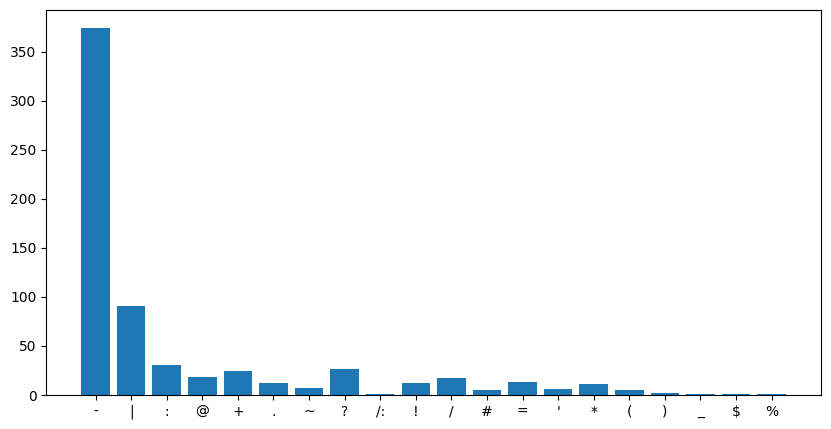

In [9]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
        
x,y=zip(*dic.items())
plt.bar(x,y)


When it comes to handling punctuation in NLP projects, there are a few different strategies that can be used, depending on the specific task and the goals of the project:

Removing punctuation: This can be done by using regular expressions or string methods to remove all punctuation marks from the text data. This strategy is often used when the focus is on identifying patterns and features that are specific to the task, and the punctuation is not needed for the analysis.

Keeping punctuation: This strategy is used when the focus is on understanding the overall meaning or context of a sentence or passage, and the punctuation is important for the analysis.

Replacing punctuation with special tokens: This strategy is used when the focus is on understanding the overall meaning or context of a sentence or passage, and the punctuation is important for the analysis, but it is needed to be represented differently. This can be done by replacing all punctuation marks with special tokens, such as "PUNCT", to indicate their presence in the text.

### Looking for missing data

<AxesSubplot: >

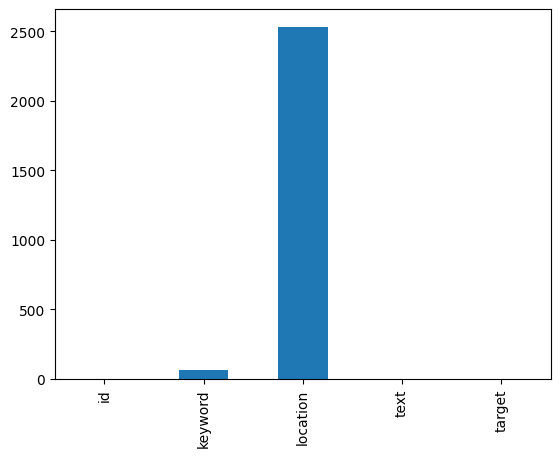

In [10]:
train.isnull().sum().plot(kind='bar')

### Data splitting (sampling)

In [11]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, train.target.values, 
                                                  stratify=train.target.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

## 2- Data cleaning


In [12]:
#df= pd.concat([train,test])
#df.shape

##3 Removing urls¶


In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [14]:
train['text']=train['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_URL(x))



### Romoving Emojis¶


In [15]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)



In [16]:
train['text']=train['text'].apply(lambda x : remove_punct(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))



In [17]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [18]:
train['text']=train['text'].apply(lambda x : remove_emoji(x))
test['text']=test['text'].apply(lambda x : remove_emoji(x))


### Remove punctuation

In [19]:
import string


string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
punctuation_to_remove = '"#$%&\'()*+-/<=>@[\\]^_`{|}~'

'''
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
'''

regular_punct = list(punctuation_to_remove)
def remove_punctuation(text, punctuation_to_remove):
    for punc in punctuation_to_remove:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip()


In [21]:
train['text']=train['text'].apply(lambda x : remove_punctuation(x,punctuation_to_remove))
test['text']=test['text'].apply(lambda x : remove_punctuation(x,punctuation_to_remove))


### Spelling Correction¶


In [22]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        


In [23]:
'''
train['text']=train['text'].apply(lambda x : correct_spellings(x))
test['text']=test['text'].apply(lambda x : correct_spellings(x))
'''

"\ntrain['text']=train['text'].apply(lambda x : correct_spellings(x))\ntest['text']=test['text'].apply(lambda x : correct_spellings(x))\n"

In [24]:
from textblob import TextBlob
def spell_correction(df):
    return df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [25]:
spell_correction(train)
spell_correction(test)



0                   Must happened a terrible car crash
1    Heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                Apocalypse lighting Spokane wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

In [26]:
train['text'].head(20)

0     Our Deeds are the Reason of this earthquake Ma...
1                 Forest fire near La Ronge Sask Canada
2     All residents asked to shelter in place are be...
3     13000 people receive wildfires evacuation orde...
4     Just got sent this photo from Ruby Alaska as s...
5     RockyFire Update  California Hwy 20 closed in ...
6     flood disaster Heavy rain causes flash floodin...
7     Im on top of the hill and I can see a fire in ...
8     Theres an emergency evacuation happening now i...
9      Im afraid that the tornado is coming to our area
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah WAIT A...
12    raining flooding Florida TampaBay Tampa 18 or ...
13                Flood in Bago Myanmar We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                         Whats up man
16                                        I love fruits
17                                     Summer is

## TPU Cluster Resolver
A Tensor Processing Unit (TPU) is an AI accelerator developed by Google specifically for TensorFlow, a popular open-source machine learning library. TPUs are designed to accelerate the training and inference of deep neural networks, and they are particularly well-suited for tasks such as image and speech recognition, natural language processing, and other types of machine learning. TPUs can be used on-premises or in the cloud, and they are available through Google's Cloud TPU service.

A TPU Cluster Resolver is a tool used to specify the location of TPU resources (e.g. TPU devices or TPU pods) when running TensorFlow programs. It allows the user to connect to TPUs on different platforms, such as Google Cloud TPUs or TPUs on a local machine, by specifying the appropriate resolver configuration. This allows for more flexibility in where TensorFlow programs can be run and makes it easier to switch between different TPU environments.

In natural language processing (NLP) and recurrent neural networks (RNNs), there are a lot of matrix multiplications and other mathematical operations that need to be performed. TPUs can greatly accelerate these operations, allowing for faster training and inference times. Additionally, TPUs can be used to perform large-scale distributed training, which can further speed up the training process.

## TPU Cluster Resolver
A Tensor Processing Unit (TPU) is an AI accelerator developed by Google specifically for TensorFlow, a popular open-source machine learning library. TPUs are designed to accelerate the training and inference of deep neural networks, and they are particularly well-suited for tasks such as image and speech recognition, natural language processing, and other types of machine learning. TPUs can be used on-premises or in the cloud, and they are available through Google's Cloud TPU service.

A TPU Cluster Resolver is a tool used to specify the location of TPU resources (e.g. TPU devices or TPU pods) when running TensorFlow programs. It allows the user to connect to TPUs on different platforms, such as Google Cloud TPUs or TPUs on a local machine, by specifying the appropriate resolver configuration. This allows for more flexibility in where TensorFlow programs can be run and makes it easier to switch between different TPU environments.

In natural language processing (NLP) and recurrent neural networks (RNNs), there are a lot of matrix multiplications and other mathematical operations that need to be performed. TPUs can greatly accelerate these operations, allowing for faster training and inference times. Additionally, TPUs can be used to perform large-scale distributed training, which can further speed up the training process.

In [27]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


Maximum nuber of words that can be present in a comment 

In [28]:
train['text'].apply(lambda x:len(str(x).split())).max()

31

Writing a function for getting auc score for validation


In [29]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    #f1_score = metrics.f1_score(target, predictions ) #average="micro" weighted macro
    #accuracy = metrics.accuracy_score(target, predictions)
    return roc_auc


# 3- Data vizualisation

# 4- Machine Learning

# 5- Deep Learning 

Deep learning is a subset of machine learning that utilizes artificial neural networks with many layers, also known as deep neural networks. These networks are modeled after the structure and function of the human brain and are designed to automatically learn features and representations from data.

Deep learning models are trained using a large dataset, where the model is presented with input data and the desired output, and the model's parameters are adjusted to minimize the difference between its output and the desired output. This process is repeated multiple times, until the model's performance on the training data is satisfactory.

The key advantage of deep learning models is that they can automatically learn features and representations from data, without the need for manual feature engineering. This is particularly useful for tasks such as image recognition, natural language processing, and speech recognition, where the amount of data and complexity of the task make it infeasible to manually design features.

Deep learning has been used to achieve state-of-the-art performance on various tasks such as image classification, object detection, speech recognition, natural language processing, and more. It also used in various other industries like healthcare, finance and self-driving cars. 

In our case we are going to use it for Natural Language Processing (NLP).


## 5-1 RNN

In this project we are going to use RNN.

### 5-1-1 Definition 
Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer. 

A recurrent newral network can be thought of as multiple copies of the same network, each passing a message to a successor. This type of flow of information through time (or sequence) in a recurrent neural network is shown in the diagram below, which unrolls the sequence (loop unrolled)

### 5-1-2 RNN components 
It consists of several components that work together to process sequential data:

- Input layer: The input layer receives the input data, which can be a sequence of words, a time series, or any other type of sequential data.

- Recurrent layer: The recurrent layer is the core of the RNN, where the network maintains an internal hidden state that captures information about the previous input. This hidden state is passed to the next recurrent layer as input, allowing the network to maintain context and understand the meaning of the input over a sequence of words.

- Activation function: The recurrent layer applies an activation function to the input and hidden state to produce the output. Commonly used activation functions include the sigmoid, tanh, and ReLU functions.

- Output layer: The output layer produces the final predictions or output of the network.

- Weights and biases: The recurrent layer, output layer, and any other layers of the network have a set of parameters, including weights and biases, that are learned during the training process. These parameters determine the behavior of the network and are adjusted to minimize the difference between the network's predictions and the desired output.

- Backpropagation through time (BPTT): BPTT is an algorithm used to train recurrent neural networks (RNNs). It is an extension of the backpropagation algorithm which is commonly used to train feedforward neural networks.
The key difference between backpropagation and BPTT is that BPTT allows the gradient to propagate through the entire sequence of inputs, rather than just the current input. This is necessary because the hidden state of an RNN depends on the previous inputs in the sequence, and the network's parameters need to be adjusted to minimize the difference between the network's predictions and the desired output for the entire sequence.

BPTT follows the same process as the standard backpropagation algorithm, but it unrolls the recurrent network and replicates the network's weights for each time step. This allows the gradients to flow through all of the time steps, effectively backpropagating the error through the entire sequence.

It's worth noting that BPTT can be computationally expensive, especially for long sequences, as it requires the calculation of gradients for each element in the sequence. There are some variations of BPTT like Truncated Backpropagation Through Time (TBPTT) that can alleviate this issue by only considering a subset of the sequence.

It's also worth mentioning that BPTT is a powerful algorithm and it has been used to train a wide range of RNNs for various tasks, including natural language processing, speech recognition, and time series prediction.

Overall, BPTT is an important component of training RNNs, and it allows the network to learn from sequences of data by propagating errors through time.

### 5-1-3 Backpropagation

Backpropagation is an algorithm used to train feedforward neural networks and other types of neural networks. The basic idea behind backpropagation is to propagate the error backwards through the network, starting from the output layer, and adjust the network's parameters to minimize the error.

The process of backpropagation is as follows:

1 - The input data is presented to the network, and the network produces an output.
2 - The error between the network's predictions and the desired output is calculated.
3 - The error is propagated backwards through the network, starting from the output layer. The gradient of the error with respect to the network's parameters is calculated at each layer.
4 - The gradients are used to update the network's parameters, using an optimization algorithm such as stochastic gradient descent (SGD).

Backpropagation is a powerful algorithm that allows the network to learn from the data, and it is the foundation for training feedforward neural networks and other types of neural networks.

It's worth noting that backpropagation has some limitations, for example it can be sensitive to the initial values of the parameters and it can get stuck in poor local optima. However, many techniques have been developed to address these issues and make backpropagation more effective.



RNNs can be unrolled to have multiple layers of recurrent units, which is called deep RNNs. RNNs can also be extended to include attention mechanisms, which allow the model to focus on specific parts of the input when making predictions. These variations are called LSTM and GRU respectively.

![image.png](attachment:image.png)

This unrolled network shows how we can supply a stream of data (intimately related to sequences, lists and time-series data) to the recurrent neural network.

## 5-2 Tokenization

### 5-2-1 Definition 
Tokenization is the process of breaking down a piece of text into smaller, more manageable pieces called tokens. These tokens can be individual words, phrases, or even sentences. Tokenization is a crucial step in many natural language processing (NLP) tasks, such as text classification, machine translation, and text generation.

There are several methods for tokenizing text, including:

- Word tokenization: This method breaks down the text into individual words. This is the most common form of tokenization and is used in many NLP tasks.

- Sentence tokenization: This method breaks down the text into individual sentences. This can be useful in tasks such as text summarization and text generation.

- Character tokenization: This method breaks down the text into individual characters. This can be useful in tasks such as text generation and language modeling.

- Subword tokenization: This method breaks down the text into subword units. Subword tokenization can be useful in tasks such as machine translation, where rare and out-of-vocabulary words can be composed of smaller units.

- Regular Expression: Tokenization using regular expressions can be used to extract specific parts of the text, such as email addresses, phone numbers, and URLs.

Most of the time, tokenization is done using pre-trained models and libraries. For example, NLTK and spaCy are popular libraries for tokenization in Python, and the tokenization functions provided by these libraries are based on machine learning models that are trained on large amounts of data.


In RNN we input a sentence word by word. We represent every word as one hot vectors of dimensions : Numbers of words in Vocab +1.

### 5-2-2 Keras Tokenizer 
Keras Tokenizer takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.
Try printing first 2 elements of xtrain_seq you will see every word is represented as a digit now

In [30]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None) # Tokenizer can convert a list of text into a list of sequences of integers, where each integer is a index of a token in the vocabulary.
max_len = 50

token.fit_on_texts(list(xtrain) + list(xvalid)) # Method used to create a vocabulary of words from a list of text documents.

xtrain_seq = token.texts_to_sequences(xtrain) # Method used to tokenize text into subwords using techniques like Byte-Pair Encoding.
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
# method takes a list of sequences as input and pads each sequence with a specific value (usually 0) until all sequences have the same length. The method takes several optional parameters.
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len) 
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

# You can also retrieve the word index using :
word_index = token.word_index

### 5-2-3 Explaning Byte-Pair Encoding
Byte-Pair Encoding (BPE) is a subword tokenization method that can be used to split words into smaller units called subwords or subword units. It is particularly useful for handling out-of-vocabulary words and rare words that may not be present in the training data.

The basic idea behind BPE is to iteratively replace the most frequent pair of bytes (or characters) in the text with a new, unique byte. This process is repeated until a predefined vocabulary size is reached. The resulting subword units are then used as the basic units of the vocabulary.

The process of BPE can be described as follows:

- Start with an initial vocabulary of individual characters.
- Find the pair of characters that appear most frequently in the text.
- Replace the pair of characters with a new, unique character.
- Add the new character to the vocabulary.
- Repeat steps 2-4 until the desired vocabulary size is reached.

#### Looking into the sequences

This following cell will output a list of sequences, where each sequence is a list of integers. The integers represent the index of the token in the vocabulary.

In [31]:
xtrain_seq

[[3597,
  203,
  345,
  799,
  3598,
  2453,
  6,
  3599,
  1159,
  714,
  3600,
  3,
  1,
  2,
  6954,
  3601,
  3602],
 [3603,
  2921,
  1751,
  4633,
  42,
  1619,
  66,
  40,
  59,
  13,
  4,
  1047,
  41,
  519,
  3,
  1,
  2,
  6955,
  3,
  1,
  2,
  6956],
 [6957, 9, 6958, 3604, 24, 5, 1106, 6, 21, 378, 87, 520, 1048, 6959],
 [6960, 992, 28, 5, 422, 130],
 [263,
  1620,
  500,
  256,
  2922,
  31,
  13,
  547,
  441,
  11,
  22,
  950,
  175,
  3,
  1,
  2,
  6961],
 [200,
  5,
  6962,
  130,
  3605,
  37,
  218,
  8,
  1621,
  16,
  243,
  6,
  84,
  2923,
  9,
  117,
  12,
  183],
 [951,
  4634,
  82,
  107,
  189,
  399,
  295,
  2924,
  54,
  79,
  442,
  8,
  1622,
  13,
  114,
  3,
  1,
  2,
  6963,
  3,
  1,
  2,
  6964],
 [4635, 34, 278, 6965, 32, 19, 4, 1752, 9, 34, 443, 12, 55, 1404, 1405],
 [4636, 95, 1753, 19, 150, 7, 594, 4, 6966, 8, 15, 905, 73, 3, 1, 2, 6967],
 [60, 296, 76, 24, 14, 46, 14, 49, 835, 3, 1, 2, 6968],
 [6969,
  61,
  152,
  49,
  5,
  6970,
  6971,
 

#### Looking into the padded sequences

This will output a 2D array of padded sequences, where each sequence has a length of 50 (max_length we assigned before). The value used for padding is 0 by default.


In [32]:
xtrain_pad


array([[    0,     0,     0, ...,  6954,  3601,  3602],
       [    0,     0,     0, ...,     1,     2,  6956],
       [    0,     0,     0, ...,   520,  1048,  6959],
       ...,
       [    0,     0,     0, ...,  3552,    12,   883],
       [    0,     0,     0, ...,     1,     2, 19589],
       [    0,     0,     0, ...,    68,    65,  4385]], dtype=int32)

#### Looking into the word index :


In [33]:
word_index



{'t': 1,
 'co': 2,
 'http': 3,
 'the': 4,
 'a': 5,
 'in': 6,
 'to': 7,
 'of': 8,
 'and': 9,
 'i': 10,
 'is': 11,
 'for': 12,
 'on': 13,
 'you': 14,
 'my': 15,
 'with': 16,
 'that': 17,
 'it': 18,
 'at': 19,
 'by': 20,
 'this': 21,
 'from': 22,
 'https': 23,
 'are': 24,
 'be': 25,
 'was': 26,
 'have': 27,
 'like': 28,
 'amp': 29,
 'as': 30,
 'up': 31,
 'me': 32,
 'but': 33,
 'just': 34,
 'so': 35,
 'not': 36,
 'your': 37,
 'out': 38,
 'no': 39,
 'all': 40,
 'after': 41,
 'will': 42,
 'has': 43,
 'an': 44,
 'fire': 45,
 'when': 46,
 "i'm": 47,
 'if': 48,
 'get': 49,
 'we': 50,
 'now': 51,
 'new': 52,
 'via': 53,
 'more': 54,
 '2': 55,
 'about': 56,
 'or': 57,
 'news': 58,
 'people': 59,
 'what': 60,
 'he': 61,
 'one': 62,
 'they': 63,
 'how': 64,
 'been': 65,
 'over': 66,
 'who': 67,
 "it's": 68,
 'into': 69,
 "don't": 70,
 'do': 71,
 'video': 72,
 "'": 73,
 'can': 74,
 'emergency': 75,
 'disaster': 76,
 'there': 77,
 'police': 78,
 'than': 79,
 '3': 80,
 'her': 81,
 'u': 82,
 'would': 8

## 5-3 Implementing a simple RNN model

In [34]:
%%time 
# it will time the cell execution time.

with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model_simple_RNN = Sequential()
    # the first layer is an embedding layer. this layer converts the input integers (which represent words) into dense vectors of fixed size (300) 
    model_simple_RNN.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len)) # max length of the input sequence.
    model_simple_RNN.add(SimpleRNN(100)) # adds a SimpleRNN layer to the model with 100 units. This layer is used to learn the sequential information from the input sequence.
    model_simple_RNN.add(Dense(1, activation='sigmoid')) # The Dense layer to the model with one unit and a sigmoid activation function. This layer is used to make predictions from the sequential information learned by the SimpleRNN layer.
    model_simple_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # compiles the model, configuring the training process. The loss function is binary_crossentropy, the optimizer used is Adam and the metrics are accuracy.
    
    
model_simple_RNN.summary()

2023-01-28 02:23:18.459538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 02:23:18.459823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-28 02:23:18.459891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-28 02:23:18.459935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-28 02:23:18.459967: W tensorflow/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           6810300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6,850,501
Trainable params: 6,850,501
Non-trainable params: 0
_________________________________________________________________
CPU times: user 314 ms, sys: 1.01 s, total: 1.32 s
Wall time: 1.58 s


#### Explaining Binary Cross Entropy (BCE)
Binary Cross-Entropy (BCE) loss is a commonly used loss function for binary classification problems. The binary classification refers to the problem of classifying an input into one of two classes, usually represented by the labels 0 and 1.

The BCE loss function calculates the difference between the predicted probability and the true label. More formally, let's assume that we have N examples, and that the predicted probability of the ith example belonging to class 1 is y_i and the true label is t_i. The BCE loss is defined as:

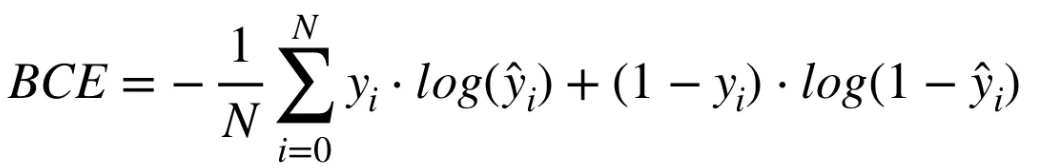

#### Model Training 

- epochs : the number of times the model will iterate over the entire training data. One epoch is completed when the model has seen all the training samples once.
- batch_size : the number of samples per gradient update. The model will update the weights after each batch of samples
- The batch_size is multiplied by strategy.num_replicas_in_sync which is the number of replicas of the model, this is used when training models using TensorFlow's tf.distribute.Strategy API, which is used to distribute the training across multiple devices and machines. By multiplying the batch_size with strategy.num_replicas_in_sync the model will update the weights after each batch of samples for all the replicas of the model.

In [35]:
model_simple_RNN.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)


Epoch 1/5
96/96 [==============================] - 4s 32ms/step - loss: 0.5882 - accuracy: 0.6892
Epoch 2/5
96/96 [==============================] - 3s 32ms/step - loss: 0.1740 - accuracy: 0.9414
Epoch 3/5
96/96 [==============================] - 3s 31ms/step - loss: 0.0599 - accuracy: 0.9811
Epoch 4/5
96/96 [==============================] - 3s 30ms/step - loss: 0.0389 - accuracy: 0.9880
Epoch 5/5
96/96 [==============================] - 3s 31ms/step - loss: 0.0215 - accuracy: 0.9929


The accuracy jumped from 0.69 to almost 1, which means that we are overfitting.

In [36]:
scores_simple_RNN = model_simple_RNN.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores_simple_RNN, yvalid)))

48/48 [==============================] - 0s 5ms/step
Auc: 0.81%


In [37]:
# Storing scores of models to compare them at the end
scores_model = {}
auc_score = []

auc_score.append(roc_auc(scores_simple_RNN,yvalid))



## 5-4 Word Embedding

Another approach (other than tokenization) is to use word embeddings, which are dense, low-dimensional representations of words that capture their meaning and context. Word embeddings can be pre-trained on a large dataset of text and can be fine-tuned on a specific task using an RNN.

word embeddings are type of word representation that allows words with similar meaning to have a similar representation.
word embedding are in fact a class of techniques where individual words are represented by a real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.
 

In [38]:
train["text"]

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    ariaahrary TheTawniest The out of control wild...
7610                 M194 0104 UTC5km S of Volcano Hawaii
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7613, dtype: object

#### Glove 

The latest approach to getting word Embeddings is using pretained GLoVe or using Fasttext.
GloVe (Global Vectors for Word Representation) is a method for creating word embeddings, which are vector representations of words that capture the meaning and context of the word in a numerical form. 


In [39]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('Data/glove.840B.300d.txt','r',encoding='utf-8')  # pre-trained GloVe embeddings
for line in tqdm(f):
    values = line.split(' ')  # To separate the word and the values of the embedding.
    word = values[0] # Assigning the first element of the resulting list, which is the word, to the variable "word".
    coefs = np.asarray([float(val) for val in values[1:]]) # The purpose of the float values in the code is to convert the string representation of these values in the text file into a numerical representation that can be used as input to a machine learning model.
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [01:34, 23207.40it/s]

Found 2196017 word vectors.


## 5-5 Long-Short Term Memory networks (LSTM)

Long-Short Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) that are able to handle long-term dependencies in sequential data. RNNs are able to process sequential data by maintaining a hidden state that summarizes the information from the previous time steps. However, standard RNNs are not able to handle long-term dependencies because the hidden state is reset after each time step.

LSTMs were introduced to overcome this limitation by introducing a new type of hidden state called the cell state. The cell state is able to maintain information over a longer period of time and can selectively choose which information to keep and which to discard based on the current input and the previous hidden state. 

This is achieved by introducing three gates in the LSTM:
- The input gate: controls the flow of information into the cell state.
- The forget gate: controls which information to discard from the previous cell state.
- The output gate: controls the flow of information from the cell state to the hidden state.

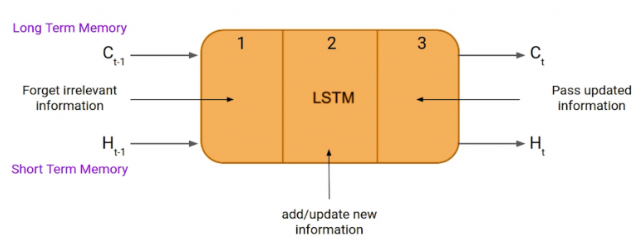

For further explanations :
https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/ 

### 5-5-1 Creating embedding matrix

An embedding matrix is used in LSTM to map discrete input variables, such as words in a sentence, to a continuous vector space. This allows the model to learn and make use of the relationships between the input variables, as well as capture more complex patterns in the data. Additionally, using an embedding matrix can also greatly reduce the dimensionality of the input data, which can improve the efficiency and performance of the model.

In [40]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 22700/22700 [00:00<00:00, 396939.49it/s]


### 5-5-2 LSTM Model Implementation

In [41]:

%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model_LSTM = Sequential()
    
    # Building the embedding layer and passing the created embedding matrix as weights to the layer instead of training it over vocabulary
    # the first layer is an embedding layer. this layer converts the input integers (which represent words) into dense vectors of fixed size (300) 
    model_LSTM.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix], # The embedding matrix (weights) is initialized with pre-trained GloVe 
                     input_length=max_len, 
                     trainable=False)) # the trainable parameter is set to False, which means that the embeddings will not be updated during training.

    model_LSTM.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) # dropout rate of 0.3 for both the input and recurrent connections. This helps to prevent overfitting by randomly disabling a fraction of the units during training.
    model_LSTM.add(Dense(1, activation='sigmoid'))
    model_LSTM.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           6810300   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,970,801
Trainable params: 160,501
Non-trainable params: 6,810,300
_________________________________________________________________
CPU times: user 252 ms, sys: 65.2 ms, total: 317 ms
Wall time: 203 ms


In [42]:
model_LSTM.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
96/96 [==============================] - 8s 61ms/step - loss: 0.5023 - accuracy: 0.7578
Epoch 2/5
96/96 [==============================] - 6s 63ms/step - loss: 0.4285 - accuracy: 0.8102
Epoch 3/5
96/96 [==============================] - 6s 59ms/step - loss: 0.4101 - accuracy: 0.8163
Epoch 4/5
96/96 [==============================] - 6s 59ms/step - loss: 0.3934 - accuracy: 0.8279
Epoch 5/5
96/96 [==============================] - 6s 58ms/step - loss: 0.3747 - accuracy: 0.8379


In [43]:
scores_LSTM = model_LSTM.predict(xvalid_pad)

auc_score.append(roc_auc(scores_LSTM,yvalid))


48/48 [==============================] - 1s 12ms/step


as we can see the auc is 0.89, which has increased.

# 5-6 GRU's (Gated Recurrent Unit)
 


### 5-6-1 Definition

Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results. If you are not familiar with Recurrent Neural Networks, I recommend reading my brief introduction. For a better understanding of LSTM, many people recommend Christopher Olah’s article. I would also add this paper which gives a clear distinction between GRU and LSTM.


### 5-6-2  Vanishing problem
As more layers using certain activation function are added to the neural networks, the gradients of the loss function approaches zero, making the network hard to train.
Certain activation functions, like the sigmoid function squishes a large input space into small input space between 0 and 1. Therefore, a large change in the input of the sigmoide function will cause a small change in the output. Hencem the derivative becomes small.

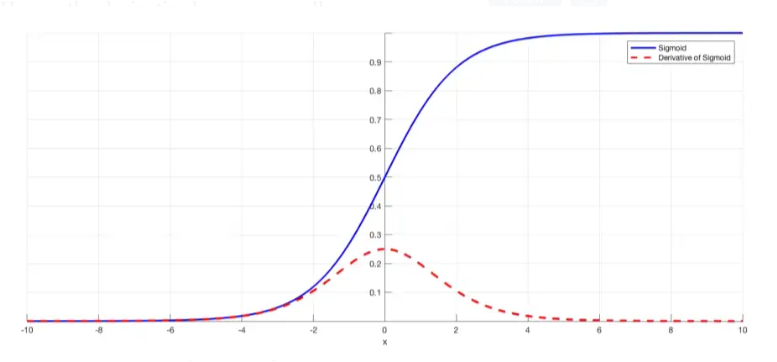

As we can see when the input of the sigmoid function becomes larger or smaller, the derivative becomes close to zero.
All sigmoid functions are monotonic and have a bell-shaped first derivative. There are several sigmoid functions and some of the best-known are presented below:

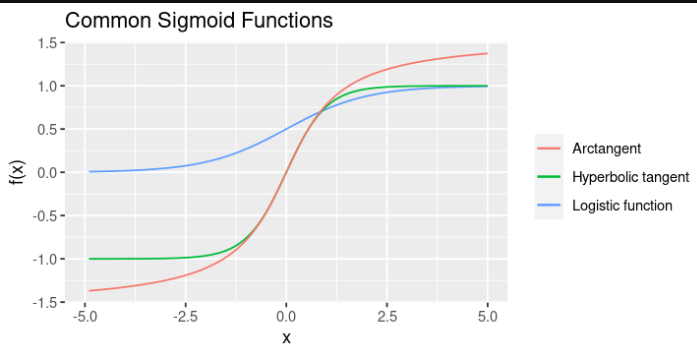

### Logestic tangent function formula
the logestic function takes any real valued input, and outputs a value between zero and one. 



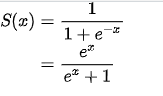

### Hyperbolic Tangent Function Formula

this maps any real valued input to the range between -1 and 1

### Arctangent Function Formula

the arctangent function maps any real valued input to the range -pi/2 to pi/2.


When the number of layers in the neural network is huge, it can cause the gradient to be too small for training to work effectively.
Gredients of neural network are found using backpropagation. It finds the derivatives of the network by moving layer by layer from the final layer to the initial one.By the chain rule, the derivatives of each layer are multiplied down the network (from the final layer to the initial) to compute the derivatives of the initial layers.
However, when n hidden layers use an activation like the sigmoid function, n small derivatives are multiplied together. Thus, the gradient decreases exponentially as we propagate down to the initial layers.
A small gradient means that the weights and biases of the initial layers will not be updated effectively with each training session. Since these initial layers are often crucial to recognizing the core elements of the input data, it can lead to overall inaccuracy of the whole network.


### 5-6-3 Solution of vanishing gradient problem   => GRU
To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.


### 5-6-4 GRU Implementation code 

In [44]:
%%time 
with strategy.scope():
    model_GRU = Sequential()
    # the first layer is an embedding layer. this layer converts the input integers (which represent words) into dense vectors of fixed size (300) 
    model_GRU.add(Embedding(len(word_index)+1, 300, 
                        weights=[embedding_matrix], # The embedding matrix (weights) is initialized with pre-trained GloVe 
                        input_length=max_len,
                        trainable=False))
    
    model_GRU.add(SpatialDropout1D(0.3)) # The second layer is a SpatialDropout1D layer. This layer randomly sets input units to 0 with a frequency of rate at each step during training time. which help prevent overfitting. 30% of the input units will be set to 0.
    model_GRU.add(GRU(300)) # the third layer is s GRU layer, a gated recurrent unit layer used for processing seauential data. the number of units in the layer is 300.
    model_GRU.add(Dense(1, activation='sigmoid'))  # The fourth layer is a Dense layer, a sigmoid activation function. with 1 output.
    
    # the model is compiled with a binary_crossentropy loss function which is commonly used for binary classification problens and adam optimizer.
    model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    

model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           6810300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 300)          0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 7,352,401
Trainable params: 542,101
Non-trainable params: 6,810,300
_________________________________________________________________
CPU times: user 300 ms, sys: 27.1 ms, total: 327 ms
Wall time: 230 ms


### 5-6-5 GRU Prediction

In [45]:
model_GRU.fit(xtrain_pad, ytrain, epochs=10, batch_size=64*strategy.num_replicas_in_sync)


Epoch 1/10
96/96 [==============================] - 10s 85ms/step - loss: 0.5325 - accuracy: 0.7392
Epoch 2/10
96/96 [==============================] - 8s 80ms/step - loss: 0.4384 - accuracy: 0.8046
Epoch 3/10
96/96 [==============================] - 9s 90ms/step - loss: 0.4165 - accuracy: 0.8156
Epoch 4/10
96/96 [==============================] - 8s 85ms/step - loss: 0.3969 - accuracy: 0.8245
Epoch 5/10
96/96 [==============================] - 9s 91ms/step - loss: 0.3848 - accuracy: 0.8320
Epoch 6/10
96/96 [==============================] - 9s 92ms/step - loss: 0.3606 - accuracy: 0.8443
Epoch 7/10
96/96 [==============================] - 9s 91ms/step - loss: 0.3388 - accuracy: 0.8565
Epoch 8/10
96/96 [==============================] - 9s 89ms/step - loss: 0.3245 - accuracy: 0.8645
Epoch 9/10
96/96 [==============================] - 8s 89ms/step - loss: 0.2946 - accuracy: 0.8777
Epoch 10/10
96/96 [==============================] - 9s 89ms/step - loss: 0.2740 - accuracy: 0.8818


In [46]:
scores_GRU = model_GRU.predict(xvalid_pad)
auc_score.append(roc_auc(scores_GRU,yvalid))


48/48 [==============================] - 2s 43ms/step


# 5-7 Bi-directional LSTM

In [47]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model_bi_dir_LSTM = Sequential()
    model_bi_dir_LSTM.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model_bi_dir_LSTM.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model_bi_dir_LSTM.add(Dense(1,activation='sigmoid'))
    model_bi_dir_LSTM.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model_bi_dir_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           6810300   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 8,253,301
Trainable params: 1,443,001
Non-trainable params: 6,810,300
_________________________________________________________________
CPU times: user 286 ms, sys: 104 ms, total: 390 ms
Wall time: 256 ms


In [48]:
model_bi_dir_LSTM.fit(xtrain_pad, ytrain, epochs=10, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/10
96/96 [==============================] - 21s 191ms/step - loss: 0.5035 - accuracy: 0.7565
Epoch 2/10
96/96 [==============================] - 18s 187ms/step - loss: 0.4323 - accuracy: 0.8125
Epoch 3/10
96/96 [==============================] - 19s 195ms/step - loss: 0.4127 - accuracy: 0.8177
Epoch 4/10
96/96 [==============================] - 18s 189ms/step - loss: 0.3989 - accuracy: 0.8235
Epoch 5/10
96/96 [==============================] - 18s 184ms/step - loss: 0.3800 - accuracy: 0.8328
Epoch 6/10
96/96 [==============================] - 19s 194ms/step - loss: 0.3534 - accuracy: 0.8440
Epoch 7/10
96/96 [==============================] - 18s 186ms/step - loss: 0.3299 - accuracy: 0.8588
Epoch 8/10
96/96 [==============================] - 18s 186ms/step - loss: 0.3077 - accuracy: 0.8672
Epoch 9/10
96/96 [==============================] - 18s 188ms/step - loss: 0.2800 - accuracy: 0.8859
Epoch 10/10
96/96 [==============================] - 18s 192ms/step - loss: 0.2576 - accura

In [49]:
scores_bi_dir_LSTM = model_bi_dir_LSTM.predict(xvalid_pad)
auc_score.append(roc_auc(scores_bi_dir_LSTM,yvalid))



48/48 [==============================] - 2s 37ms/step


In [50]:
model_Comparaison = pd.DataFrame(
    {
        'Model' : ['Simple RNN', 'LSTM', 'GRU', 'Bi-directional LSTM'],
        'AUC Score' : auc_score
    }
)

In [51]:
model_Comparaison

,Model,AUC Score
0,Simple RNN,0.814697
1,LSTM,0.889914
2,GRU,0.871978
3,Bi-directional LSTM,0.869670


## 5-7 Attention Models
